In [173]:
from pydoc import describe

from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

In [174]:
# Variables
# Paramètres de connexion MySQL
db_url = "jdbc:mysql://mysql-container:3306/wildlens?serverTimezone=UTC"
db_properties = { "user": "root",
                  "password": "root",
                  "driver": "com.mysql.cj.jdbc.Driver" }
mysql_driver_path = os.path.abspath("installation/mysql-connector-j-9.1.0.zip")

In [175]:
# Initialisation de SparkSession
spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", "mysql_driver_path") \
    .getOrCreate()

print("✅ Spark initialisé avec le driver MySQL :", mysql_driver_path)
print(spark.sparkContext.getConf().get("spark.jars"))


✅ Spark initialisé avec le driver MySQL : /home/cedric/PycharmProjects/MSPR_ETL/ETL/installation/mysql-connector-j-9.1.0.zip
mysql_driver_path


25/03/05 20:20:56 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [176]:
try:
    # 📌 Tentative de lecture des tables MySQL
    df_tables = spark.read.jdbc(url=db_url, table="information_schema.tables", properties=db_properties)

    # 📌 Affichage des tables disponibles dans la base `wildlens`
    df_tables.filter(df_tables["TABLE_SCHEMA"] == "wildlens").select("TABLE_NAME").show()

    print("✅ Connexion à MySQL réussie et tables listées avec succès !")

except Exception as e:
    print(f"❌ Erreur de connexion à MySQL : {e}")

❌ Erreur de connexion à MySQL : An error occurred while calling o1491.jdbc.
: java.lang.ClassNotFoundException: com.mysql.cj.jdbc.Driver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:593)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:526)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:103)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:41)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRe

# Gestion des métadonnées des espèces

 Dans un premier temps, nous scannons les dossiers disponibles afin d'en faire un dataframe et réutiliser ces informations.
 Puis nous récupérons les métadonnées depuis l'API Mistral grâce à un prompt optimisé (optimisation du grounding, du prompt engineering)
 un sleep de 3s a été ajouté afin d'éviter de trop spam l'API
 -- transféré dans un fichier à part --

In [177]:
folder_all_animals = [d for d in os.listdir("ressource/image/train") if os.path.isdir(os.path.join("ressource/image/train", d))]
df_all_animals = pd.DataFrame(folder_all_animals, columns=["Nom du dossier"])

# Gestion des images
Dans un premier temps, nous allons faire une première analyse des images: leurs nombre par espèces (donc, par dossier), leurs tailles moyenne, leurs poid moyen, etc...

,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne
0,turkey,105,411.371429,398.304762
1,mouse,129,152.310078,159.891473
2,horse,71,383.521127,340.492958
3,gray_fox,126,278.182540,283.531746
4,goose,141,329.971631,311.737589
5,mink,139,302.273381,293.719424
6,coyote,123,359.276423,405.422764
7,bob_cat,171,250.976608,258.438596
8,skunk,122,442.180328,504.950820
9,black_bear,186,447.930108,421.924731


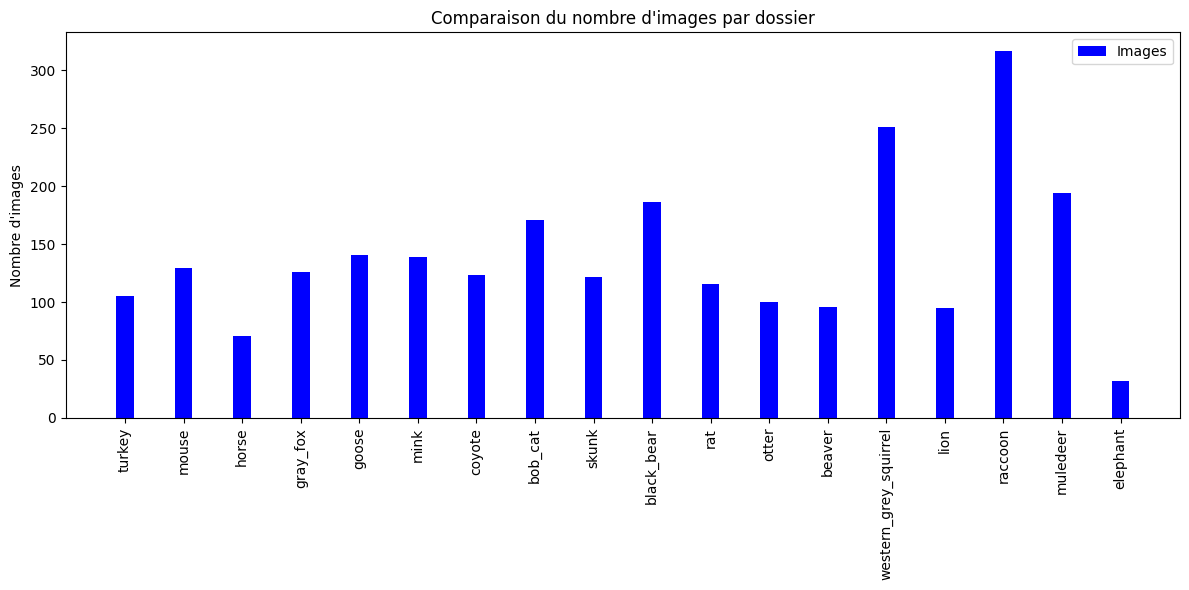

In [178]:
# Définition des chemins des datasets
image = "ressource/image/train"
# Fonction pour récupérer les infos des images d'un dossier (en gérant les dossiers absents)
def get_image_info(folder_path):
    if not os.path.exists(folder_path):  # 📌 Vérifie si le dossier existe
        return 0, None, None  # ⚠️ Si absent → 0 images et tailles nulles

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    num_images = len(image_files)

    if num_images == 0:
        return num_images, None, None  # Aucun fichier image

    widths, heights = [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_width = sum(widths) / len(widths) if widths else None
    avg_height = sum(heights) / len(heights) if heights else None

    return num_images, avg_width, avg_height

# Listes pour stocker les infos
image_data = []

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(image, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
df_image = pd.DataFrame(image_data, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])

# Affichage du DataFrame de comparaison
display(df_image)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = df_image["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, df_image["Nombre d'images"], width=0.3, label="Images", color='blue')

plt.xticks([x for x in x_range], x_labels, rotation=90)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()



# Augmentation des images
## Data Augmentation et Transformation des Données
La Data Augmentation est une technique utilisée en apprentissage automatique, notamment en vision par ordinateur et en traitement du langage naturel (NLP), pour augmenter la diversité des données d'entraînement sans collecter de nouvelles données. Elle permet de rendre les modèles plus robustes et d'améliorer leur généralisation.

- Calculer la Mediane du nombre des images
- Determiner le Q3 afin que le nombre d'image finale de chaque animale se rapproche
- Calculer le coefficient de multiplication pour chaque classe d'animaux
- Modifier et sauvegarder les nouvelles images
-

In [179]:
# 📂 Définition du chemin des images
image = "ressource/image/train"
augmented_image_folder = "ressource/image/augmented_train"

# 📝 Étape 1 : Calculer la médiane et Q3 du nombre d'images
median_images = df_image["Nombre d'images"].median()
q3_images = df_image["Nombre d'images"].quantile(0.75)

print(f"Médiane: {median_images}, Q3: {q3_images}")


Médiane: 124.5, Q3: 163.5


In [180]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import albumentations as A

# Création du dossier de sortie s'il n'existe pas
os.makedirs(augmented_image_folder, exist_ok=True)

# Détermination du coefficient de Data Augmentation
df_image["Coeff"] = np.ceil(q3_images / df_image["Nombre d'images"])

# Définition des transformations
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.GaussNoise(p=0.1),
    A.Resize(256, 256)
])

# Boucle sur chaque classe d’animaux
for index, row in df_image.iterrows():
    if row["Coeff"] < 4 :
        folder_name = row["Nom du dossier"]
        coeff = int(row["Coeff"])

        original_folder = os.path.join(image, folder_name)
        augmented_folder = os.path.join(augmented_image_folder, folder_name)
        os.makedirs(augmented_folder, exist_ok=True)

        image_files = [f for f in os.listdir(original_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

        for img_file in image_files:
            img_path = os.path.join(original_folder, img_file)
            img = cv2.imread(img_path)  # Lecture avec OpenCV (BGR)

            if img is None:
                print(f"❌ Erreur de lecture de l'image {img_file}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Conversion en RGB (évite les problèmes de couleur)

            for i in range(coeff):  # Générer plusieurs images augmentées
                augmented = augmentation(image=img)["image"]
                new_img_path = os.path.join(augmented_folder, f"aug_{i}_{img_file}")
                cv2.imwrite(new_img_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))  # Sauvegarde avec OpenCV

print("✅ Data Augmentation terminée avec succès !")


✅ Data Augmentation terminée avec succès !


,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne
0,turkey,210,256.0,256.0
1,mouse,258,256.0,256.0
2,horse,213,256.0,256.0
3,gray_fox,252,256.0,256.0
4,goose,282,256.0,256.0
5,mink,278,256.0,256.0
6,coyote,246,256.0,256.0
7,bob_cat,171,256.0,256.0
8,skunk,244,256.0,256.0
9,black_bear,186,256.0,256.0


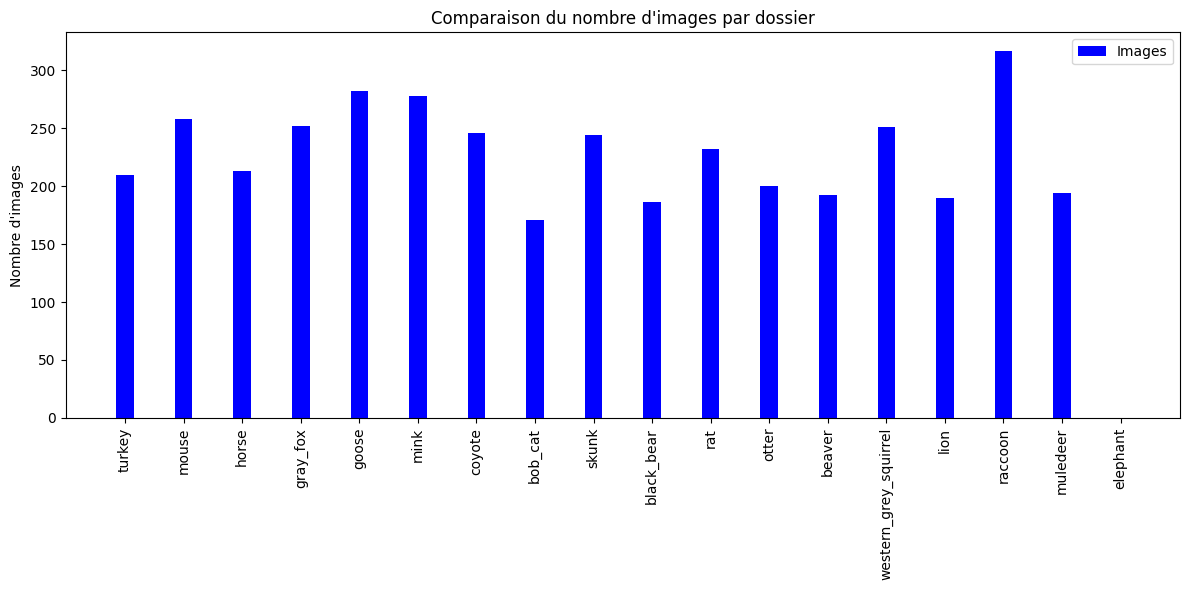

In [181]:
# Listes pour stocker les infos
image_data_new = []
image_new = "ressource/image/augmented_train"

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(image_new, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data_new.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
image_data_new = pd.DataFrame(image_data_new, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
image_data_new["Coeff"] = df_image["Coeff"]
# Affichage du DataFrame de comparaison
display(image_data_new)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = image_data_new["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, image_data_new["Nombre d'images"], width=0.3, label="Images", color='blue')

plt.xticks([x for x in x_range], x_labels, rotation=90)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()

In [182]:
display(image_data_new)

,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne
0,turkey,210,256.0,256.0
1,mouse,258,256.0,256.0
2,horse,213,256.0,256.0
3,gray_fox,252,256.0,256.0
4,goose,282,256.0,256.0
5,mink,278,256.0,256.0
6,coyote,246,256.0,256.0
7,bob_cat,171,256.0,256.0
8,skunk,244,256.0,256.0
9,black_bear,186,256.0,256.0


,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne,Coeff
0,turkey,105,411.371429,398.304762,2.0
1,mouse,129,152.310078,159.891473,2.0
2,horse,71,383.521127,340.492958,3.0
3,gray_fox,126,278.182540,283.531746,2.0
4,goose,141,329.971631,311.737589,2.0
5,mink,139,302.273381,293.719424,2.0
6,coyote,123,359.276423,405.422764,2.0
7,bob_cat,171,250.976608,258.438596,1.0
8,skunk,122,442.180328,504.950820,2.0
9,black_bear,186,447.930108,421.924731,1.0


## Labélisation
Le dataframe d'images et les métadata sont fusionnées afin que chaque image corresponde à des métadonnées : c'est la labélisation.

In [188]:
df_metadata = pd.read_csv("./ressource/metadata.csv")

df_merged = pd.merge(image_data_new, df_metadata, left_on='Nom du dossier', right_on='Espèce anglais', how='left')
df_merged = df_merged.drop(columns=["Nom du dossier", "Largeur Moyenne", "Hauteur Moyenne"])
print(df_merged)
df_merged.to_csv("./ressource/data_merged.csv", header=True)

if print(df_merged['Espèce anglais'].isna().sum()):
    print("Toutes les lignes ont trouvés une correspondance")
display(df_merged)

           Nom du dossier  Nombre d'images  Largeur Moyenne  Hauteur Moyenne  \
0                  turkey              210            256.0            256.0   
1                   mouse              258            256.0            256.0   
2                   horse              213            256.0            256.0   
3                gray_fox              252            256.0            256.0   
4                   goose              282            256.0            256.0   
5                    mink              278            256.0            256.0   
6                  coyote              246            256.0            256.0   
7                 bob_cat              171            256.0            256.0   
8                   skunk              244            256.0            256.0   
9              black_bear              186            256.0            256.0   
10                    rat              232            256.0            256.0   
11                  otter              2

,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne,Espèce anglais,Espèce français,Famille,Nom latin,Description,Population estimée,Localisation
0,turkey,210,256.0,256.0,turkey,Dinde,Phasianidae,Meleagris gallopavo,"Oiseau de grande taille au plumage coloré, ori...",550000000,États-Unis Mexique
1,mouse,258,256.0,256.0,mouse,souris,Muridae,Mus musculus,Petit rongeur avec de grandes oreilles et une ...,600000000,Monde entier
2,horse,213,256.0,256.0,horse,cheval,Equidae,Equus ferus caballus,"Mammifère quadrupède au corps robuste, au cou ...",58000000,France États-Unis Russie Chine
3,gray_fox,252,256.0,256.0,gray_fox,Renard gris,Canidae,Urocyon cinereoargenteus,Le renard gris est un petit canidé aux poils g...,4000000,États-Unis Mexique Canada
4,goose,282,256.0,256.0,goose,oie,Anatidae,Anser anser,L'oie est un grand oiseau aquatique avec un co...,2500000,Canada États-Unis Russie
5,mink,278,256.0,256.0,mink,Vison d'Europe,Mustelidae,Neogale vison,Petit mammifère semi-aquatique avec un pelage ...,1000000,"France, Allemagne, Pologne, Russie"
6,coyote,246,256.0,256.0,coyote,Coyote,Canidae,Canis latrans,"Le coyote est un canidé de taille moyenne, ave...",3000000,États-Unis Canada Mexique
7,bob_cat,171,256.0,256.0,bob_cat,Chat domestique,Felidae,Felis catus,Petit félin domestique au pelage court et aux ...,600000000,France États-Unis Royaume-Uni
8,skunk,244,256.0,256.0,skunk,Putois,Mustelidae,Mephitis mephitis,Le putois est un petit mammifère carnivore con...,3200000,États-Unis Canada
9,black_bear,186,256.0,256.0,black_bear,Ours noir,Ursidae,Ursus americanus,L'ours noir est un ours de taille moyenne avec...,900000,Canada États-Unis Mexique


# State
Ajout d'un state aléatoire sur chaque image.

70% de train (1)

15% de test (2)

15% de val (3)

Ceci servira prochainement pour l'entrainement du model de machine learning


In [201]:
from pyspark.sql.functions import rand, when, col

df_merged_spark = spark.createDataFrame(df_merged)
image_new = "ressource/image/augmented_train"

df_dict = {}
for dossier in df_merged_spark.select("Nom du dossier").distinct().rdd.flatMap(lambda x: x).collect():
    folder_path = os.path.join(image_new, dossier)
    if os.path.exists(folder_path):
        df_images = spark.createDataFrame([(dossier, os.path.join(dossier, img)) for img in os.listdir(folder_path)],
                                          ["Nom du dossier", "Chemin Relatif"])
        df_dict[dossier] = df_images.join(df_merged_spark, on="Nom du dossier", how="left")

for dossier, df in df_dict.items():
    df.write.mode("overwrite").parquet(f"ressource/dataframes_parquet/{dossier}")
    df.write.mode("overwrite").csv(f"ressource/dataframes_csv/{dossier}")

train_ratio = 0.8
val_ratio = 0.1

for dossier, df in df_dict.items():

    df = df.withColumn(
        "state",
        when(col("rand_val") <= train_ratio, 1)
        .when(col("rand_val") <= (train_ratio + val_ratio), 2)
        .otherwise(3)
    )

    df_dict[dossier] = df

    df.write.mode("overwrite").parquet(f"ressource/dataframes_parquet/{dossier}")
    df.write.mode("overwrite").csv(f"ressource/dataframes_csv/{dossier}")

    print(f"✅ State ajouté et fichier enregistré pour {dossier}")

from functools import reduce
from pyspark.sql import DataFrame

if df_dict:
    df_final = reduce(DataFrame.unionAll, df_dict.values())
    print(f" Fusion complète ! Le DataFrame final contient {df_final.count()} images.")
    df_final.write.mode("overwrite").parquet("ressource/dataframes_parquet/all_images")
    df_final.coalesce(1).write.mode("overwrite").csv("ressource/dataframes_csv/all_images", header=True)
else:
    print("⚠️ Aucun DataFrame à fusionner !")



25/03/05 21:19:52 INFO CodeGenerator: Code generated in 13.749512 ms
25/03/05 21:19:52 INFO DAGScheduler: Registering RDD 5520 (javaToPython at NativeMethodAccessorImpl.java:0) as input to shuffle 1039
25/03/05 21:19:52 INFO DAGScheduler: Got map stage job 1933 (javaToPython at NativeMethodAccessorImpl.java:0) with 16 output partitions
25/03/05 21:19:52 INFO DAGScheduler: Final stage: ShuffleMapStage 3074 (javaToPython at NativeMethodAccessorImpl.java:0)
25/03/05 21:19:52 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:19:52 INFO DAGScheduler: Missing parents: List()
25/03/05 21:19:52 INFO DAGScheduler: Submitting ShuffleMapStage 3074 (MapPartitionsRDD[5520] at javaToPython at NativeMethodAccessorImpl.java:0), which has no missing parents
25/03/05 21:19:52 INFO MemoryStore: Block broadcast_2389 stored as values in memory (estimated size 28.1 KiB, free 432.8 MiB)
25/03/05 21:19:52 INFO MemoryStore: Block broadcast_2389_piece0 stored as bytes in memory (estimated size 13.1 

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `rand_val` cannot be resolved. Did you mean one of the following? [`Famille`, `Nom latin`, `Description`, `Localisation`, `Chemin Relatif`].;
'Project [Nom du dossier#11962, Chemin Relatif#11963, Nombre d'images#11940L, Largeur Moyenne#11941, Hauteur Moyenne#11942, Espèce anglais#11943, Espèce français#11944, Famille#11945, Nom latin#11946, Description#11947, Population estimée#11948L, Localisation#11949, CASE WHEN ('rand_val <= 0.8) THEN 1 WHEN ('rand_val <= 0.9) THEN 2 ELSE 3 END AS state#12642]
+- Project [Nom du dossier#11962, Chemin Relatif#11963, Nombre d'images#11940L, Largeur Moyenne#11941, Hauteur Moyenne#11942, Espèce anglais#11943, Espèce français#11944, Famille#11945, Nom latin#11946, Description#11947, Population estimée#11948L, Localisation#11949]
   +- Join LeftOuter, (Nom du dossier#11962 = Nom du dossier#11939)
      :- LogicalRDD [Nom du dossier#11962, Chemin Relatif#11963], false
      +- LogicalRDD [Nom du dossier#11939, Nombre d'images#11940L, Largeur Moyenne#11941, Hauteur Moyenne#11942, Espèce anglais#11943, Espèce français#11944, Famille#11945, Nom latin#11946, Description#11947, Population estimée#11948L, Localisation#11949], false


root
 |-- Nom du dossier: string (nullable = true)
 |-- Chemin Relatif: string (nullable = true)
 |-- Nombre d'images: long (nullable = true)
 |-- Largeur Moyenne: double (nullable = true)
 |-- Hauteur Moyenne: double (nullable = true)
 |-- Espèce anglais: string (nullable = true)
 |-- Espèce français: string (nullable = true)
 |-- Famille: string (nullable = true)
 |-- Nom latin: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Population estimée: long (nullable = true)
 |-- Localisation: string (nullable = true)
 |-- state: integer (nullable = false)



25/03/05 21:27:39 INFO CodeGenerator: Code generated in 7.009043 ms
25/03/05 21:27:39 INFO DAGScheduler: Registering RDD 6071 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 1145
25/03/05 21:27:39 INFO DAGScheduler: Got map stage job 2112 (showString at NativeMethodAccessorImpl.java:0) with 16 output partitions
25/03/05 21:27:39 INFO DAGScheduler: Final stage: ShuffleMapStage 3376 (showString at NativeMethodAccessorImpl.java:0)
25/03/05 21:27:39 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:27:39 INFO DAGScheduler: Missing parents: List()
25/03/05 21:27:39 INFO DAGScheduler: Submitting ShuffleMapStage 3376 (MapPartitionsRDD[6071] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
25/03/05 21:27:39 INFO MemoryStore: Block broadcast_2604 stored as values in memory (estimated size 15.2 KiB, free 433.2 MiB)
25/03/05 21:27:39 INFO MemoryStore: Block broadcast_2604_piece0 stored as bytes in memory (estimated size 8.0 KiB, free 

+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-----+
|Nom du dossier|      Chemin Relatif|Nombre d'images|Largeur Moyenne|Hauteur Moyenne|Espèce anglais|Espèce français|    Famille|          Nom latin|         Description|Population estimée|      Localisation|state|
+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-----+
|        turkey|turkey/aug_1_2493...|            210|          256.0|          256.0|        turkey|          Dinde|Phasianidae|Meleagris gallopavo|Oiseau de grande ...|         550000000|États-Unis Mexique|    1|
|        turkey|turkey/aug_0_2442...|            210|          256.0|          256.0|        turkey|          Dinde|Phasianidae|Meleagris gallop

25/03/05 21:27:41 INFO SparkContext: Created broadcast 2633 from broadcast at DAGScheduler.scala:1585
25/03/05 21:27:41 INFO DAGScheduler: Submitting 16 missing tasks from ShuffleMapStage 3422 (MapPartitionsRDD[6161] at count at <unknown>:0) (first 15 tasks are for partitions Vector(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14))
25/03/05 21:27:41 INFO TaskSchedulerImpl: Adding task set 3422.0 with 16 tasks resource profile 0
25/03/05 21:27:41 INFO DAGScheduler: Registering RDD 6163 (count at <unknown>:0) as input to shuffle 1172
25/03/05 21:27:41 INFO DAGScheduler: Got map stage job 2141 (count at <unknown>:0) with 16 output partitions
25/03/05 21:27:41 INFO DAGScheduler: Final stage: ShuffleMapStage 3423 (count at <unknown>:0)
25/03/05 21:27:41 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:27:41 INFO DAGScheduler: Missing parents: List()
25/03/05 21:27:41 INFO DAGScheduler: Submitting ShuffleMapStage 3423 (MapPartitionsRDD[6163] at count at <unknown>:0), which has 

Nombre total d'images : 3916
Colonnes : ['Nom du dossier', 'Chemin Relatif', "Nombre d'images", 'Largeur Moyenne', 'Hauteur Moyenne', 'Espèce anglais', 'Espèce français', 'Famille', 'Nom latin', 'Description', 'Population estimée', 'Localisation', 'state']


25/03/05 21:27:44 INFO DAGScheduler: Registering RDD 6249 (toPandas at /tmp/ipykernel_6676/3968468374.py:6) as input to shuffle 1195
25/03/05 21:27:44 INFO DAGScheduler: Got map stage job 2166 (toPandas at /tmp/ipykernel_6676/3968468374.py:6) with 16 output partitions
25/03/05 21:27:44 INFO DAGScheduler: Final stage: ShuffleMapStage 3484 (toPandas at /tmp/ipykernel_6676/3968468374.py:6)
25/03/05 21:27:44 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:27:44 INFO DAGScheduler: Missing parents: List()
25/03/05 21:27:44 INFO DAGScheduler: Submitting ShuffleMapStage 3484 (MapPartitionsRDD[6249] at toPandas at /tmp/ipykernel_6676/3968468374.py:6), which has no missing parents
25/03/05 21:27:44 INFO PythonRunner: Times: total = 100, boot = -283, init = 383, finish = 0
25/03/05 21:27:44 INFO MemoryStore: Block broadcast_2660 stored as values in memory (estimated size 15.2 KiB, free 432.9 MiB)
25/03/05 21:27:44 INFO PythonRunner: Times: total = 103, boot = -320, init = 423, finis

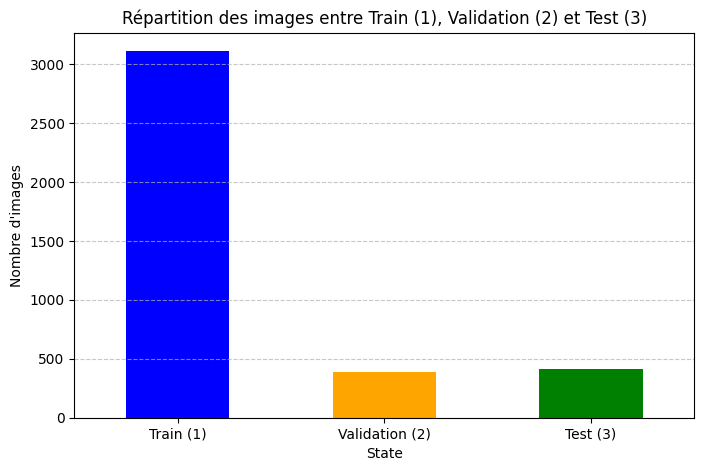

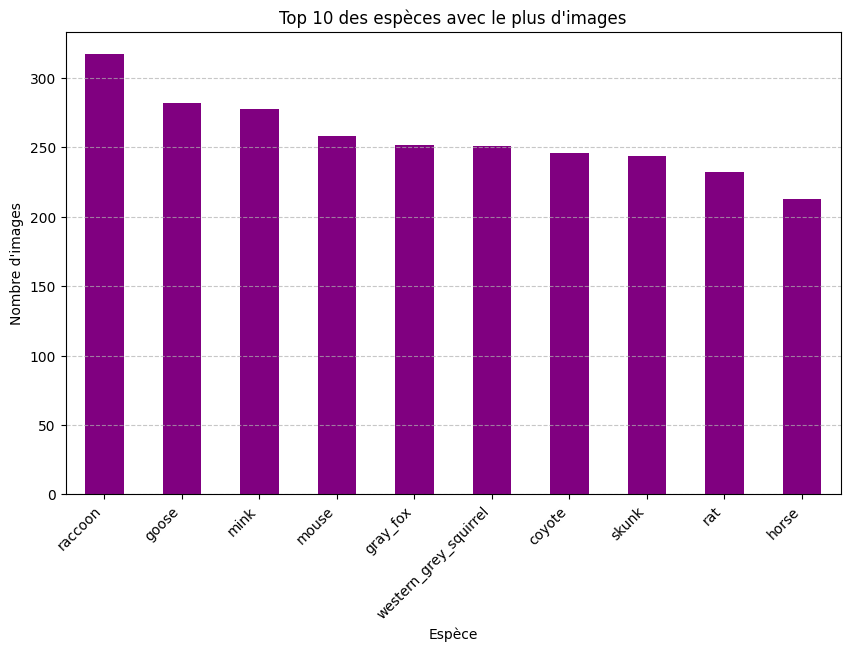

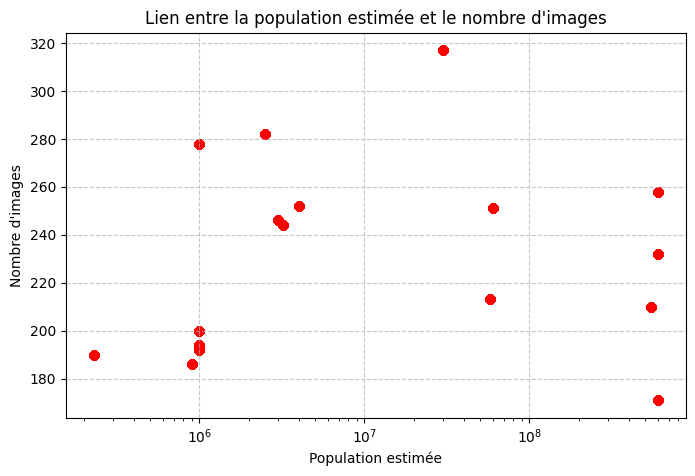

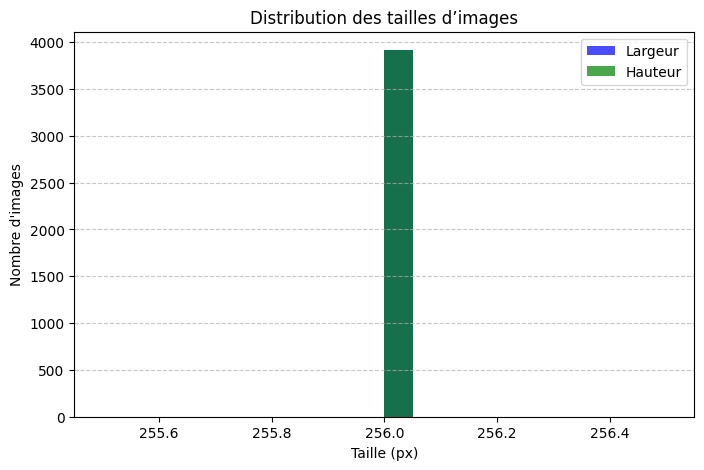

In [203]:
df_final.printSchema()
df_final.show(10)
print(f"Nombre total d'images : {df_final.count()}")
print(f"Colonnes : {df_final.columns}")

df_pandas = df_final.toPandas()

# Compter les occurrences des états (1 = train, 2 = val, 3 = test)
state_counts = df_pandas["state"].value_counts().sort_index()

# 📊 Création du graphique
plt.figure(figsize=(8, 5))
state_counts.plot(kind='bar', color=['blue', 'orange', 'green'])

plt.xlabel("State")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images entre Train (1), Validation (2) et Test (3)")
plt.xticks(ticks=[0, 1, 2], labels=["Train (1)", "Validation (2)", "Test (3)"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

# Compter le nombre d'images par espèce
species_counts = df_pandas["Espèce anglais"].value_counts().head(10)  # Top 10

# 📊 Création du graphique
plt.figure(figsize=(10, 6))
species_counts.plot(kind='bar', color='purple')

plt.xlabel("Espèce")
plt.ylabel("Nombre d'images")
plt.title("Top 10 des espèces avec le plus d'images")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(df_pandas["Population estimée"], df_pandas["Nombre d'images"], alpha=0.5, color='red')

plt.xlabel("Population estimée")
plt.ylabel("Nombre d'images")
plt.title("Lien entre la population estimée et le nombre d'images")
plt.xscale("log")  # Pour une meilleure visibilité
plt.grid(True, linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

In [185]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, monotonically_increasing_id, lit
import os
import base64

# 📌 Configuration de Spark avec JDBC MySQL
db_url = "jdbc:mysql://mysql-container:3306/wildlens?serverTimezone=UTC"
db_properties = {
    "user": "root",
    "password": "root",
    "driver": "com.mysql.cj.jdbc.Driver"
}

spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", "ETL/installation/mysql-connector-j-9.1.0.zip") \
    .getOrCreate()

# 📌 Chargement des métadonnées avec Spark
species_info_path = "data/csv/metadata.csv"
df_species = spark.read.option("header", True).option("sep", ",").csv(species_info_path)

# 📌 Nettoyage des localisations (gestion des zones)
df_species = df_species.withColumn("Localisation", split(col("Localisation"), ", "))

# 📌 Extraire les zones uniques
zones = df_species.selectExpr("explode(Localisation) as localisation").distinct()
zones = zones.withColumn("id_zone", monotonically_increasing_id())

# 📌 Insérer les zones dans `wildlens_d2_zone`
zones.write.jdbc(url=db_url, table="wildlens_d2_zone", mode="append", properties=db_properties)

# 📌 Récupération des ID des zones
zones_dict = {row["localisation"]: row["id_zone"] for row in zones.collect()}

# 📌 Associer chaque espèce à sa zone principale
def get_zone_id(localisation):
    return zones_dict.get(localisation[0], None) if localisation else None

get_zone_id_udf = spark.udf.register("get_zone_id", get_zone_id)
df_species = df_species.withColumn("id_zone", get_zone_id_udf(col("Localisation")))

# 📌 Sélection et insertion des espèces dans `wildlens_d3_especes`
df_species_filtered = df_species.select(
    col("Espèce").alias("espece"),
    col("Famille").alias("famille"),
    col("Nom latin").alias("nom_latin"),
    col("id_zone")
)

df_species_filtered.write.jdbc(url=db_url, table="wildlens_d3_especes", mode="append", properties=db_properties)

# 📌 Récupération des ID des espèces
species_df = spark.read.jdbc(url=db_url, table="wildlens_d3_especes", properties=db_properties)
species_dict = {row["espece"]: row["id_espece"] for row in species_df.collect()}

# 📌 Chargement des images et conversion en base64 pour MySQL
base_path = "data/OpenAnimalTracks/image"
image_data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        if img_file.lower().endswith(("png", "jpg", "jpeg")):
            try:
                with open(img_path, "rb") as image_file:
                    encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
                image_data.append((encoded_image,))
            except Exception as e:
                print(f"Erreur avec {img_path}: {e}")

# 📌 Création d'un DataFrame Spark avec les images
df_images = spark.createDataFrame(image_data, ["image_base64"])

# 📌 Envoi des images dans `wildlens_d1_images`
df_images.write.jdbc(url=db_url, table="wildlens_d1_images", mode="append", properties=db_properties)

# 📌 Récupération des ID des images
image_df = spark.read.jdbc(url=db_url, table="wildlens_d1_images", properties=db_properties)
image_ids = image_df.select("id_image").rdd.flatMap(lambda x: x).collect()

# 📌 Création de `wildlens_facts`
facts_data = []
for index, row in df_species.collect():
    espece = row["Espèce"]
    id_espece = species_dict.get(espece)
    id_image = image_ids[index] if index < len(image_ids) else None
    facts_data.append((id_espece, id_image, row["Description"], row["Population estimée"]))

df_facts = spark.createDataFrame(facts_data, ["id_espece", "id_image", "description", "population_estimee"])

# 📌 Insertion dans `wildlens_facts`
df_facts.write.jdbc(url=db_url, table="wildlens_facts", mode="append", properties=db_properties)

print("✅ Données insérées avec succès via Spark !")


25/03/05 20:21:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/03/05 20:21:04 INFO InMemoryFileIndex: It took 1 ms to list leaf files for 1 paths.
25/03/05 20:21:04 INFO InMemoryFileIndex: It took 1 ms to list leaf files for 1 paths.
25/03/05 20:21:04 INFO FileSourceStrategy: Pushed Filters: 
25/03/05 20:21:04 INFO FileSourceStrategy: Post-Scan Filters: (length(trim(value#500, None)) > 0)
25/03/05 20:21:04 INFO MemoryStore: Block broadcast_36 stored as values in memory (estimated size 200.2 KiB, free 433.7 MiB)
25/03/05 20:21:04 INFO MemoryStore: Block broadcast_36_piece0 stored as bytes in memory (estimated size 34.6 KiB, free 433.7 MiB)
25/03/05 20:21:04 INFO BlockManagerInfo: Added broadcast_36_piece0 in memory on 172.20.100.137:43229 (size: 34.6 KiB, free: 434.3 MiB)
25/03/05 20:21:04 INFO SparkContext: Created broadcast 36 from csv at NativeMethodAccessorImpl.java:0
25/03/05 20:21:04 INFO FileSourceScanExec: Planning scan

Py4JJavaError: An error occurred while calling o1553.jdbc.
: java.lang.ClassNotFoundException: com.mysql.cj.jdbc.Driver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:593)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:526)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:103)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:254)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:258)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:47)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:48)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:869)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:391)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:364)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:251)
	at org.apache.spark.sql.DataFrameWriter.jdbc(DataFrameWriter.scala:766)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)


In [ ]:
# 🔄 Fonction corrigée pour éviter le shadowing et enlever le "Nombre d'images"
def get_image_info_extended(folder_path):
    if not os.path.exists(folder_path):
        return None, None, 0, 0

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    widths_list, heights_list, sizes_kb_list, total_pixels_list = [], [], [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                img_width, img_height = img.size
                file_size_kb = os.path.getsize(img_path) / 1024
                widths_list.append(img_width)
                heights_list.append(img_height)
                sizes_kb_list.append(file_size_kb)
                total_pixels_list.append(img_width * img_height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_img_width = sum(widths_list) / len(widths_list) if widths_list else None
    avg_img_height = sum(heights_list) / len(heights_list) if heights_list else None
    avg_size_kb = sum(sizes_kb_list) / len(sizes_kb_list) if sizes_kb_list else None
    avg_total_pixels = sum(total_pixels_list) / len(total_pixels_list) if total_pixels_list else None

    return avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels

# 📊 Stockage des données étendues sans "Nombre d'images"
image_data_extended = []

for folder in df_all_animals["Nom du dossier"]:
    folder_path_raw = os.path.join(image, folder)
    avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels = get_image_info_extended(folder_path_raw)
    image_data_extended.append([folder, avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels])

# 🔗 Création DataFrame mis à jour
df_extended = pd.DataFrame(image_data_extended, columns=["Nom du dossier", "Largeur Moyenne", "Hauteur Moyenne", "Poids Moyen (Ko)", "Taille Moyenne (Pixels)"])

# 👁️‍🗨️ Affichage du DataFrame
display(df_extended)

# 📊 Nouveau graphique avec axe secondaire (sans Nombre d'images)
fig, ax1 = plt.subplots(figsize=(14,7))

x_labels = df_extended["Nom du dossier"]
x_range = range(len(x_labels))

# 📏 Axe principal pour Poids et Dimensions
ax1.bar([x + 0.15 for x in x_range], df_extended["Poids Moyen (Ko)"], width=0.15, label="Poids Moyen (Ko)", color='green')
ax1.bar([x + 0.3 for x in x_range], df_extended["Largeur Moyenne"], width=0.15, label="Largeur Moyenne", color='purple')
ax1.bar([x + 0.45 for x in x_range], df_extended["Hauteur Moyenne"], width=0.15, label="Hauteur Moyenne", color='orange')

ax1.set_xlabel("Nom du dossier")
ax1.set_ylabel("Valeurs Moyennes")
ax1.set_xticks([x + 0.225 for x in x_range])
ax1.set_xticklabels(x_labels, rotation=45)

# 📊 Axe secondaire pour la Taille Moyenne (Pixels)
ax2 = ax1.twinx()
ax2.bar([x + 0.6 for x in x_range], df_extended["Taille Moyenne (Pixels)"], width=0.15, label="Taille Moyenne (Pixels)", color='red', alpha=0.5)
ax2.set_ylabel("Taille Moyenne (Pixels)")

# 🔖 Combinaison des légendes des deux axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.title("Comparaison des caractéristiques des images par dossier")
plt.tight_layout()
plt.show()
